# Points
Brian Li \
10/01/2023

This notebook contains data from power plants located in the continental United States, focusing on wind power plants to be specific.

The data were sourced from the EIA (US Energy Information Administration).

There are notably high concentrations of wind power plants in the Midwest and across the plains to northern Texas.

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 11301 entries, 1 to 11568
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   OBJECTID        11301 non-null  int64   
 1   Plant_Code      11301 non-null  int64   
 2   Plant_Name      11301 non-null  object  
 3   Utility_ID      11301 non-null  int64   
 4   Utility_Name    11297 non-null  object  
 5   sector_name     11301 non-null  object  
 6   Street_Address  11275 non-null  object  
 7   City            11282 non-null  object  
 8   County          11282 non-null  object  
 9   State           11301 non-null  object  
 10  Zip             11280 non-null  float64 
 11  PrimSource      11301 non-null  object  
 12  source_desc     11301 non-null  object  
 13  tech_desc       11301 non-null  object  
 14  Install_MW      11301 non-null  float64 
 15  Total_MW        11301 non-null  float64 
 16  Bat_MW          362 non-null    float64 
 17  Bio_

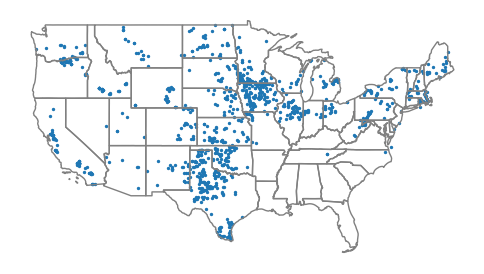

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt

pwr_plants = gpd.read_file('https://michaelminn.net/tutorials/data/2022-power-plants.geojson')
pwr_plants = pwr_plants[~pwr_plants['State'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]
pwr_plants = pwr_plants.to_crs('EPSG:3857')

wind_plants = pwr_plants[pwr_plants['Wind_MW'] > 0]

states = gpd.read_file("https://michaelminn.net/tutorials/data/2015-2019-acs-states.geojson")
states = states[~states["ST"].isin(['AK', 'HI', 'PR'])]
states = states.to_crs(pwr_plants.crs)

axis = wind_plants.plot(markersize=2)
axis.set_axis_off()
plt.rcParams['figure.dpi'] = 100
states.plot(facecolor='none', edgecolor='gray', ax=axis)

pwr_plants.info()

Higher-capacity power plants in California tend towards the coast, especially closer to the southern parts of the state in SoCal.

<AxesSubplot:>

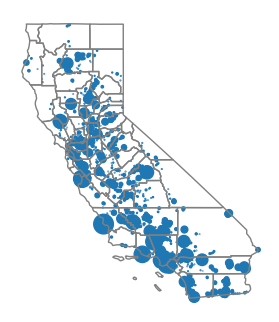

In [11]:
ca_pwr = pwr_plants[pwr_plants["State"] == "California"]
bubble_size = 200 * ca_pwr["Install_MW"] / max(ca_pwr["Install_MW"])
axis = ca_pwr.plot(markersize=bubble_size)
axis.set_axis_off()

ca_state = gpd.read_file("https://michaelminn.net/tutorials/data/2015-2019-acs-counties.geojson")
ca_state = ca_state[ca_state["ST"] == "CA"]
ca_state = ca_state.to_crs(pwr_plants.crs)

ca_state.plot(facecolor='none', edgecolor='gray', ax=axis)

Wind accounts for 11.26% of all power generated by power plants in this dataset.

The top 5 types of power by total installed capacity in the US are, in ascending order, solar (69.75 GW), nuclear (100.50 GW), wind (138.67 GW), coal (218.56 GW), and natural gas (563.30 GW).

The largest wind power plant in the US is the Traverse Wind Project in Oklahoma, coming in at 999 MW.

In [14]:
pwr_plants["PrimSource"].value_counts() / pwr_plants["PrimSource"].count() * 100

solar             41.606937
natural gas       16.883462
hydroelectric     12.140519
wind              11.264490
petroleum          6.822405
biomass            5.627821
coal               2.052916
batteries          1.557384
other              0.672507
geothermal         0.584019
nuclear            0.477834
pumped storage     0.309707
Name: PrimSource, dtype: float64

In [15]:
pwr_plants.groupby("PrimSource")["Install_MW"].sum()

PrimSource
batteries           3872.1
biomass            13859.7
coal              218562.2
geothermal          3955.7
hydroelectric      79402.3
natural gas       563299.1
nuclear           100504.3
other               2957.5
petroleum          26755.1
pumped storage     22028.8
solar              69753.2
wind              138670.3
Name: Install_MW, dtype: float64

In [17]:
wind_plants = wind_plants.sort_values("Install_MW", ascending=False)
wind_plants = wind_plants.reset_index()
wind_plants[["Plant_Name", "State", "Install_MW"]].head()

,Plant_Name,State,Install_MW
0,"Traverse Wind Project, LLC",Oklahoma,999.0
1,Horse Hollow Wind Energy Center,Texas,735.5
2,Capricorn Ridge Wind LLC,Texas,662.5
3,Fowler Ridge Wind Farm LLC,Indiana,600.3
4,Rush Creek Wind,Colorado,600.0


"The distribution of a variable is the manner in which the values are spread across the range of possible values" (https://michaelminn.net/tutorials/python-points/).

The distribution of installed capacity values for wind power plants is heavily skewed right.

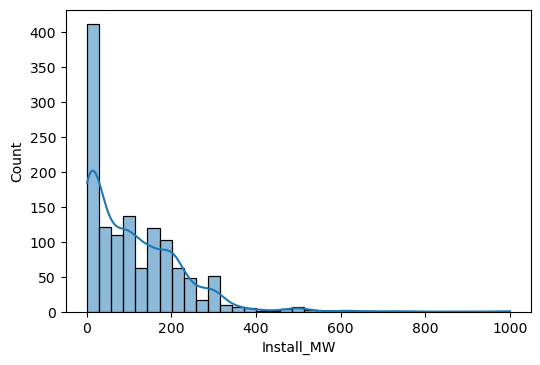

In [18]:
import seaborn as sns

sns.histplot(wind_plants["Install_MW"], kde=True)
plt.show()

"A classical method of mapping areas of high spatial autocorrelation of points is kernel density analysis, in which a kernel of a given radius is used to systematically scan an area, and the density of any particular location is the number of points within the kernel surrounding that point" (https://michaelminn.net/tutorials/python-points/).

"The bw_adjust=0.3 parameter determines the radius of the kernel and can be increased for greater smoothing or reduced for greater detail" (https://michaelminn.net/tutorials/python-points/).

There are notable concentrations of wind power plants in central Texas and Oklahoma, in a region of the Great Plains sometimes referred to as Tornado Alley.

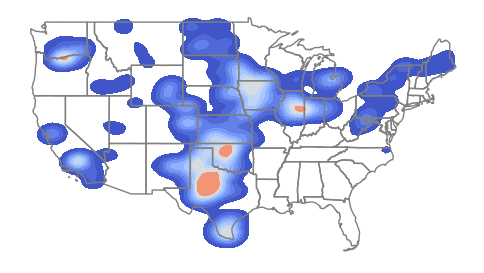

In [19]:
axis = sns.kdeplot(x = wind_plants.centroid.x, y = wind_plants.centroid.y,
        weights = wind_plants["Install_MW"],
        fill=True, gridsize=100, bw_adjust=0.3, cmap="coolwarm")

states.plot(facecolor="none", edgecolor="gray", ax=axis)
axis.set_axis_off()
plt.show()

In [20]:
wind_states = wind_plants.groupby("State")["Install_MW"].sum()
wind_states = wind_states.sort_values(ascending = False)
wind_states = wind_states.reset_index()
wind_states.head()

,State,Install_MW
0,Texas,37250.6
1,Iowa,12276.2
2,Oklahoma,11715.1
3,Kansas,8261.3
4,Illinois,7111.3


"An attribute join connects two datasets based on common key values" (https://michaelminn.net/tutorials/python-points/).

There are notable concentrations of per-capita capacity for wind power plants in the northern Midwest but that's probably because not very many people live in those states.

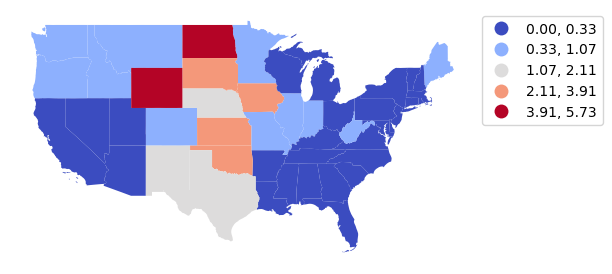

In [21]:
wind_states = states.merge(wind_states, how="left", left_on="Name", right_on="State")
wind_states["Install_MW"] = wind_states["Install_MW"].fillna(0)
wind_states["KW_Per_Capita"] = 1000 * wind_states["Install_MW"] / wind_states["Total Population"]

axis = wind_states.plot("KW_Per_Capita", legend=True, scheme="naturalbreaks", cmap="coolwarm", legend_kwds=dict(loc='upper left', bbox_to_anchor=(1, 1)))
axis.set_axis_off()
plt.show()

Most of the wind power plants are in states that Trump won.

This makes sense because a large portion of the nation's wind power capacity is in the Great Plains area, much of which is pretty solidly Red.

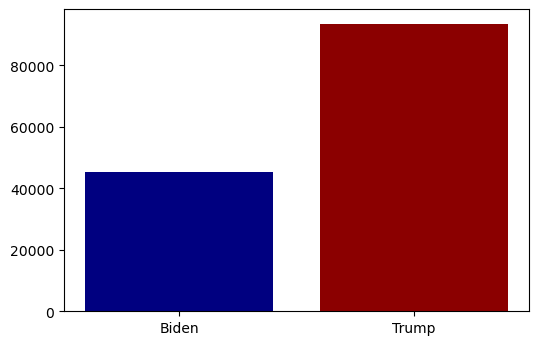

In [22]:
electoral_states = gpd.read_file("https://michaelminn.net/tutorials/data/2020-electoral-states.geojson")
electoral_states = electoral_states.to_crs(wind_plants.crs)
electoral_plants = wind_plants.sjoin(electoral_states)
electoral_plants = electoral_plants.groupby("Winner 2020")["Install_MW"].sum()
electoral_plants = electoral_plants.reset_index()

plt.bar(electoral_plants["Winner 2020"], electoral_plants["Install_MW"], color=["navy", "darkred"])
plt.show()

"Global Moran's I assesses autocorrelation over the entire area of analysis as a single number, with values of the global Moran's I statistic varying from -1 (evenly dispersed = evenly spread out) to 0 (no autocorrelation) to +1 (completely clustered)" (https://michaelminn.net/tutorials/python-points/).

The Global Moran's I value of 0.18 for wind power plants means that there is little to no spatial autocorrelation.

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.0/lib/python3.8/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


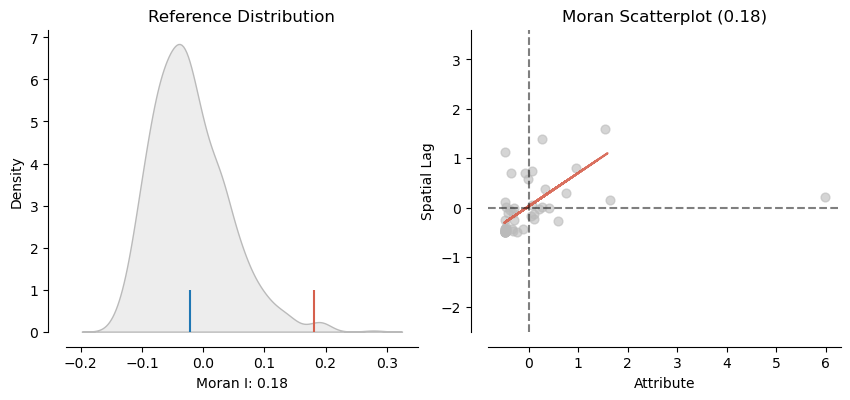

In [26]:
import pysal.lib
import pysal.model
import esda.moran
import splot.esda

state_weights = pysal.lib.weights.KNN.from_dataframe(wind_states, ids="FIPS", k=4)
moran = esda.moran.Moran(wind_states["Install_MW"], state_weights)
axis = splot.esda.plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

"LISA analysis with the local Moran's I statistic is used to identify clusters of areas with similar values and outlier areas with values that stand out among the neighbors" (https://michaelminn.net/tutorials/python-points/).

Oklahoma, in the Great Plains, has a cluster of high values of installed capacity for wind power plants.

There are no outlier states, as there are no HL or LH values.

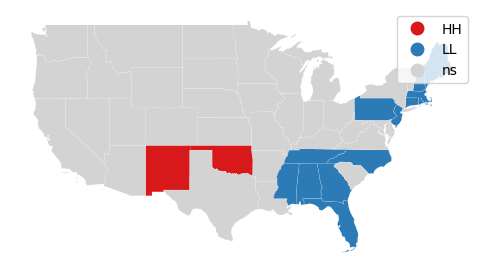

In [27]:
moran_local = esda.moran.Moran_Local(wind_states["Install_MW"], state_weights)
splot.esda.lisa_cluster(moran_local, wind_states[["Install_MW", "geometry"]])
plt.show()